# Metric Degradation Histograms

F3/F3

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

This notebook creates histograms binning basins according to their change in predictive performance metric (NSE) in a defined extreme model from the corresponding random, or unbiased, model. In other words, the histograms plots predictive degradation in a basin due to biased train/test sets.

### Import Libraries

In [1]:
#Import Python libraries
import os
import sys
import copy
import glob
import xarray
import logging
import numpy as np
from os import path
import pandas as pd
import pickle as pkl
from functions import * #load the million neuralhydrology functions I use here
from pathlib import Path
import statistics
from ruamel.yaml import YAML
from tqdm.notebook import tqdm
from scipy import stats, signal
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple, Union
from xarray.core.dataarray import DataArray

### Define Parameters

##### Experiment Parameters

We need to define which two models we want to compare. Here, I compare the SAC-SMA and LSTM (static climate inputs) models trained with forcing data from NLDAS on train/test years extracted from the total CAMELS date range, as opposed to the "nwm" date range (1995-2014). 

Adjustments necessary to allow for same-model comparison.

In [2]:
#########################################################################################

#Define two model types to compare (xxx = [model1 attribute,model2 attribute])
models = ['sacsma','nh']
inp = 'static'
forcing = 'nldas_extended'
year = 'all'

#########################################################################################

index = 'aridity'

#########################################################################################

metric = 'nse'

#########################################################################################

##### Paths

In [3]:
#########################################################################################

#Path to working_dir (current directory)
working_dir = Path(os.getcwd())

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to NH codebase (../neuralhydrology/neuralhydrology)
nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

# Path to notebook_env_saves
env_saves_dir = working_dir / 'notebook_env_saves'

#Path to nwm basin list
nwm_480 = working_dir / 'config_complementaries' / 'nwm' / 'nwm_480_basins.txt'

#########################################################################################

##### Notebook Configurations

In [4]:
plt.rcParams['axes.axisbelow'] = True

You should not have to edit anything below this cell

In [5]:
exp_types = ['random','extreme']

### Load Source Data

In [6]:
#Retreive list of cdfs files avaliable in env_saves_dir
metrics_list = [x for x in os.listdir(env_saves_dir) if x.startswith('basin_metrics')]

#Initiate dictionary to hold basin_metrics dictionarities (created in notebook 3)
metrics_dict = {}

#For each model...
for model in models:

    #For each experiment type (random & extreme)...
    for exp_type in exp_types:

        #If we are looking at an NH LSTM run...
        if model == 'nh':
            
            #Use the corresponding naming convention
            name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
            
        #If we are looking at a SAC-SMA run...
        if model == 'sacsma' or model == 'nwm':
            
            #Use the corresponding naming convention
            name = f'{model}_{exp_type}_{forcing}_{year}'

        #Manually construct a filename from name variable (assuming it already exists; sanity check)
        metrics_file = f'basin_metrics_{name}.pkl'
        
        #Try to...
        try:

            #Open the basin_metrics file...
            with open(Path(env_saves_dir / metrics_file),'rb') as f:

                #Load it
                metric_data = pkl.load(f)

            #Save dictionary under model name
            metrics_dict[name] = metric_data
        
        #If that doesn't work... continue to the next
        except: continue

In [7]:
#List of all model names from metrics_dict
model_names = list(metrics_dict.keys())

#Lists of extreme and random model names (parsed by exp_type in name)
rand_models = [x for x in model_names if 'random' in x]
ext_models = [x for x in model_names if 'extreme' in x]

#List of extreme and random experiment names (use example models to retrieve experiment names)
rand_exps = list(metrics_dict[rand_models[0]].keys())
ext_exps = list(metrics_dict[ext_models[0]].keys())
ext_exps = [x for x in ext_exps if index in x]

#List of all avaliable experiments
experiments = rand_exps + ext_exps

#Retrieve list of metrics using example model
metrics = list(metrics_dict[ext_models[0]][ext_exps[0]].keys())

In [8]:
#If one of the models is the NWM Benchmark run...
if 'nwm' in models:
    
    #Read in NWM CAMELS basin list
    with open(nwm_480, 'r') as f:
        nwm_480 = f.read()
        
    #Parse string
    basins = nwm_480.split('\n')
    
    #List of basins of type int
    basins_int = [int(x) for x in basins]
    
else:
    
    #Retrieve list of nwm basins ONLY and use as basin list
    basins = list(metrics_dict[ext_models[0]][ext_exps[0]][metrics[0]].index)
    
    #List of nwm basins of type int
    basins_int = [int(x) for x in basins]

### Plot Histograms

In [9]:
#Create a dictionary containing the mean median NSE scores for the random models and their experiments
rand_dict = {model: [] for model in rand_models}

#For each random model...
for model in rand_models:
    
    #And for each random experiment...
    for exp in rand_exps:
    
        #Append it's series of basin NSE scores into a list
        rand_dict[model].append(metrics_dict[model][exp][metric])
    
    #Concat list of series to get average nse scores for all random experiments
    rand_dict[model] = np.mean(pd.concat(rand_dict[model],axis=1),axis=1)

In [10]:
#Define function to format experiment name for plot labels
def col_name(exex):
    #Split the model name by '_'
    xs = exex.split('_')
    #Capitalize each element
    xs = [x.capitalize() for x in xs]
    #Rejoin with a space
    xs = ' '.join(xs)
    #Return new string
    return xs

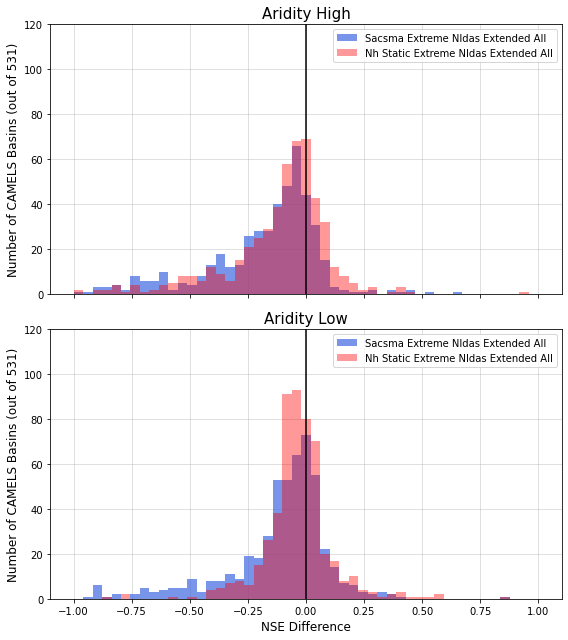

In [11]:
#Define bin range and number for histogram
bins = np.linspace(-1,1,50)

#Create 2x1 figure
fig,axs= plt.subplots(2,1,figsize=(8,9))

#For each extreme experiment...
for i,exp in enumerate(ext_exps):
    
    #Create formatted experiment name
    title = col_name(exp)
    
    #Assign default plot params
    c = 'r'
    alpha = 1
    
    #For each extreme/random model pair...
    for modele,modelr in zip(ext_models,rand_models):
        
        #Retrieve per-basin random NSE scores
        rand = rand_dict[modelr][basins]
        
        #If the model name contains 'sacsma'... (histogram color changes with model type)
        if 'sacsma' in modele:
            alpha = 0.7
            c = 'royalblue'

        #If the model name contains 'nh'...
        if 'nh' in modele:
            alpha = 0.4
            c = 'r'
            
        #If the model name contains 'nwm'...
        if 'nwm_' in modele:
            alpha = 0.5
            c = 'gold'
        
        #Retrieve per-basin extreme NSE scores for an experiment...
        ext = metrics_dict[modele][exp][metric][basins]
        
        #Calculate NSE difference (degradation)
        diff = ext - rand
        
        #Drop problem basin (optional)
        diff = diff.drop(labels = ['08202700']) #AVE NSE of inf
        
        #Plot histogram based on parameters
        axs[i].hist(diff,bins,color=c,alpha=alpha,label=col_name(modele))
    
    #Plot vertical line at 0
    axs[i].plot([0,0],[0,150],'k')
        
    #Format plot
    axs[i].legend()
    axs[i].grid(alpha=0.5)
    axs[i].set_ylim(0,120)
    axs[i].set_title(title,fontsize=15)
    
    #Only show x labels for outter plots
    for ax in axs.flat:
        ax.label_outer() 
    
    #Set x-axis label
    axs[i].set_xlabel(f'{metric.upper()} Difference',fontsize=12)
    
    #If one of the models is a nwm run, we are only comparing the nwm basins
    if 'nwm_' in models:
        
        #Set y-axis label
        axs[i].set_ylabel('Number of CAMELS Basins (out of 480)',fontsize=12)
    
    #Otherwise...
    else:
        #Set y-axis label
        axs[i].set_ylabel('Number of CAMELS Basins (out of 531)',fontsize=12)

#Show plot
plt.tight_layout()

### Extra Code

In [14]:
#make sure these correspond
for modele,modelr in zip(ext_models,rand_models):
    print(f'{modele}, {modelr}')

sacsma_extreme_nldas_extended_all, sacsma_random_nldas_extended_all
nh_static_extreme_nldas_extended_all, nh_static_random_nldas_extended_all
